# Image Colorization using CNNs - Multinomial classification model

In this second part we try to improve the results of the previous model by approaching the problem as a classification problem, the reasons why the regresion model generated desaturated images are the following:
- *mean squared error* favors low intensity colors: if an object can take a set of distinct ab values, the optimal solution wrt MSE is to predict the mean of this set, in color prediction, this averaging effect favors grayish, desaturated results
- *bright colors are rare*: the distribution of colors in the ab space is not uniform, bright colors are greatly underrepresented, this bias is reflected in the model's predictions

To solve these problems we use a classification model with class rebalancing by reweighting the loss of each color class.

The results shown in this notebook are heavily based on the paper [Colorful Image Colorization](https://arxiv.org/pdf/1603.08511.pdf) by Richard Zhang, Phillip Isola, Alexei A. Efros. Also great help was given by this repository [nn-photo-colorization](https://github.com/preslavrachev/nn-photo-colorization).

## 1. Setup: Imports and parameters

Same as before.

In [1]:
!unzip /content/drive/Shareddrives/Intelligent\ Systems/celeba10k.zip -d . | wc -l

unzip:  cannot find or open /content/drive/Shareddrives/Intelligent Systems/celeba10k.zip, /content/drive/Shareddrives/Intelligent Systems/celeba10k.zip.zip or /content/drive/Shareddrives/Intelligent Systems/celeba10k.zip.ZIP.
0


In [ ]:
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import Activation, Dense, Dropout, Flatten, InputLayer, BatchNormalization, Lambda
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.models import Sequential
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
import tensorflow as tf
import numpy as np
import os
import random
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
import scipy.ndimage
from pathlib import Path
import time

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
CELEBA_DIR = Path('/content/celeba10k')
DRIVE_DIR = Path('/content/drive/Shareddrives/Intelligent Systems')
MODELS_DIR = DRIVE_DIR / 'models'
RESULTS_DIR = DRIVE_DIR / 'results'
RESOURCES_DIR = DRIVE_DIR / 'resources'

batch_size = 16

# image width and height
H, W = (216, 176)

In [ ]:
# import the dataset as a tf.data.Dataset object and normalize the images to [0, 1]
dataset_from_directory_kwargs = {
    'labels': None,
    'image_size':(H, W),
    'seed': 42,
    'batch_size': batch_size
}

train_dataset = tf.keras.utils.image_dataset_from_directory(CELEBA_DIR / 'train', **dataset_from_directory_kwargs).map(lambda x: x/255)
val_dataset = tf.keras.utils.image_dataset_from_directory(CELEBA_DIR / 'validation', **dataset_from_directory_kwargs).map(lambda x: x/255)
test_dataset = tf.keras.utils.image_dataset_from_directory(CELEBA_DIR / 'test', **dataset_from_directory_kwargs).map(lambda x: x/255)

Found 10000 files belonging to 1 classes.
Found 1000 files belonging to 1 classes.
Found 1000 files belonging to 1 classes.


In [ ]:
def show_imgs(imgs, *, ncols=1, save_path=None):
  """Utility function to show images in a grid arrangement."""

  imgs_iter = iter(imgs)

  dpi = 80
  N, h, w, _ = imgs.shape
  fig_width = (w*ncols)/dpi
  fig_height = (h*N//ncols)/dpi

  fig, ax_rows = plt.subplots(nrows=N//ncols, ncols=ncols, dpi=dpi, figsize=(fig_width, fig_height))

  for ax_col in ax_rows:
    for ax in ax_col:
      ax.imshow(next(imgs_iter))
      ax.axis('off')

  if save_path:
    plt.savefig(save_path.format(time=time.time_ns()))
  plt.show()

## 2. Data preparation

### 2.1. Distribution of colors

Here we show that the distribution of colors is indeed strongly biased towards desaturated colors (i.e. colors with ab values close to 0).
We take a meaningful subset of the training data and plot the distribution of colors in the ab space as a 2D histogram, note that the scale of the histogram is logarithmic as shown in the legend.

In [ ]:
S = 2000
imgs = next(train_dataset.rebatch(S).take(1).as_numpy_iterator())
imgs = rgb2lab(imgs)
ab_chs = imgs[...,1:].reshape((S*W*H,2)).astype(np.int8)

del imgs

DescribeResult(nobs=76032000, minmax=(-67, 91), mean=6.417748776830808, variance=112.68538034189216, skewness=1.3298955391825598, kurtosis=5.239750537260663)
DescribeResult(nobs=76032000, minmax=(-107, 92), mean=9.847254826914984, variance=211.0644758100437, skewness=-0.07874808580812152, kurtosis=2.4824406708252837)


<ipython-input-8-59e934e2225b>:7: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(xlabels[:-1], ylabels[:-1], hist.T, norm=mpl.colors.LogNorm())


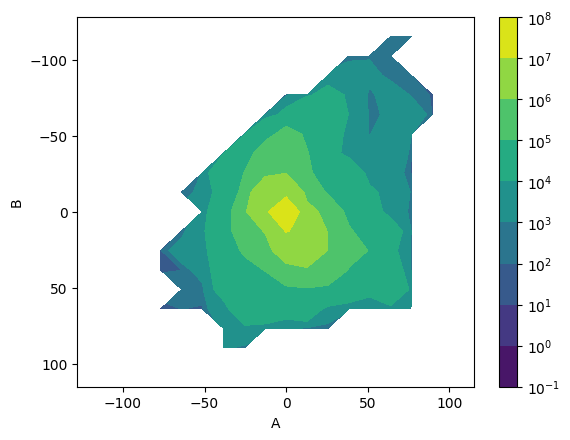

In [ ]:
x = ab_chs[:,0]
y = ab_chs[:,1]
print(scipy.stats.describe(x))
print(scipy.stats.describe(y))

hist, xlabels, ylabels = np.histogram2d(x, y, bins=20, range=[[-128, 128], [-128, 128]])
plt.contourf(xlabels[:-1], ylabels[:-1], hist.T, norm=mpl.colors.LogNorm())
plt.xlabel("A")
plt.ylabel("B")
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

In the next image we show the colors present in the training data, we can indeed see that the colors close to 0 are grayish, while the bright colors are close to the edges of the ab space.

In [ ]:
ab_present = set((a,b) for a,b in ab_chs)
print(len(ab_present))

17753


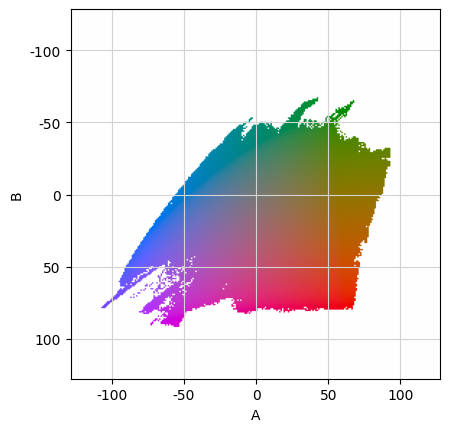

In [ ]:
lab_image = np.zeros((256, 256, 3))
lab_image[:] = [100, 0, 0] # white

for i in range(-128, 128):
  for j in range(-128, 128):
      if (i,j) in ab_present:
        lab_image[128+i,128+j] = [50, i, j]

plt.xlabel("A")
plt.ylabel("B")
ticks = np.arange(-100, 101, 50)
plt.xticks(ticks+128, ticks)
plt.yticks(ticks+128, ticks)
plt.grid(color='lightgray')

plt.imshow(lab2rgb(lab_image))

### 2.2. Class definition

Obviouslly we can't have one class for each possible (a,b) pair, that would be too many classes and probably impossible to learn. We quantize the ab space into bins of size 10, each color belongs to the class of the bin it falls into.

Essentially we round each color to the nearest multiple of 10, this lowers the number of classes to an acceptable number. It obviously makes the color space much smaller, which is good for training but bad for the visual quality of the results. Actually the image quality doesn't suffer from this color space reduction, we will show this soon.

In [ ]:
def quantize(n, *, bin_size=10):
  """Round a number to the nearest multiple of `bin_size`."""
  return np.round(n / bin_size) * bin_size

#quantize(np.arange(20), bin_size=3)

There are 225 quantized color bins


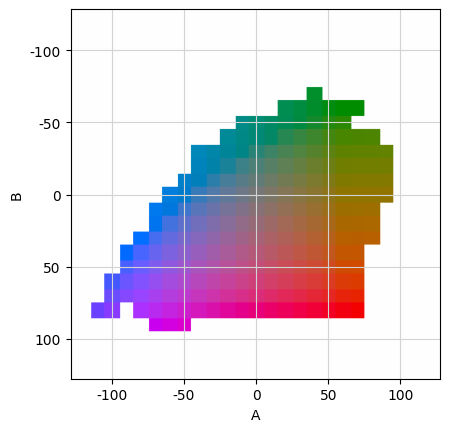

In [ ]:
ab_quantized = set((quantize(a), quantize(b)) for a,b in ab_present)
print(f"There are {len(ab_quantized)} quantized color bins")

lab_image = np.zeros((256, 256, 3))
lab_image[:] = [100, 0, 0] # white

for i in range(-128, 128):
  for j in range(-128, 128):
    ri, rj = quantize(i), quantize(j)
    if (ri, rj) in ab_quantized:
      lab_image[128+i,128+j] = [50, ri, rj]

plt.xlabel("A")
plt.ylabel("B")
ticks = np.arange(-100, 101, 50)
plt.xticks(ticks+128, ticks)
plt.yticks(ticks+128, ticks)
plt.grid(color='lightgray')

plt.imshow(lab2rgb(lab_image))

Above we show the quantized ab color space, below we show that this color reduction doesn't affect the visual quality of the results. The image shows a pair of images, the left one is the original image, the right one is the image with the quantized colors. No visible difference can be seen.

In [ ]:
rgb = next(test_dataset.rebatch(9).as_numpy_iterator())

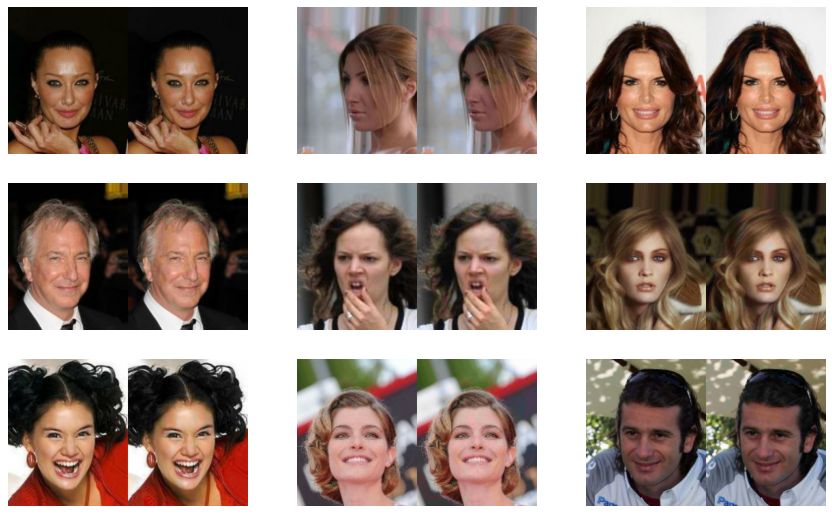

In [ ]:
lab = rgb2lab(rgb)

lab[...,1:] = quantize(lab[...,1:])
quantized_rgb = lab2rgb(lab)

imgs = np.concatenate([rgb, quantized_rgb], axis=2)
show_imgs(imgs, ncols=3, save_path=str(RESULTS_DIR / "original_vs_quantized_binsize10_{time:0x}.png"))

We proceed to calculate the classes needed to cover the whole ab space of our training data. In the code snippet below we iterate over the whole training data and keep record of each quantized (a,b) pair we find, as well as the number of times it appears in the training data. The distribution is necessary to calculate the class weights for the loss function.

Since this operation takes time we save the results to a file, so we can load them later.

In [ ]:
from collections import defaultdict

ds = train_dataset.as_numpy_iterator()

# need to find all (a,b) pairs and their frequency
classes = defaultdict(int)

for batch in train_dataset.as_numpy_iterator():
  for img in batch:
    lab = rgb2lab(img / 255.)
    ab_flat = lab[:,:,1:].reshape((W*H, 2))
    for a,b in quantize(ab_flat):
      classes[a,b] += 1

print(len(classes))

243


In [ ]:
class_to_ab = np.array(list(classes.keys()))
class_to_freq = np.array(list(classes.values()))

np.save(RESOURCES_DIR / 'class_to_ab.npy', class_to_ab)
np.save(RESOURCES_DIR / 'class_to_freq.npy', class_to_freq)

We can see that the number of classes is 243, which is a reasonable number of classes.
This is the meening of the following variables:
- `class_to_ab`: ndarray of shape (243, 2), each element is a pair of quantized (a,b) values, it means that the class `i` corresponds to the color `class_to_ab[i]`
- `class_to_freq`: ndarray of shape (243,), each element is the number of times the color `class_to_ab[i]` appears in the training data
- `smooth_class_to_freq`: smooth version of `class_to_freq` obtained with a gaussian filter, used later to calculate the class weights for the loss function

In [ ]:
class_to_ab = np.load(RESOURCES_DIR / 'class_to_ab.npy').astype(np.int_)
class_to_freq = np.load(RESOURCES_DIR / 'class_to_freq.npy')

print(f"{class_to_ab.shape=}")
print(f"{class_to_freq.shape=}")

hist = np.ones((256, 256))
hist[class_to_ab[:,0]+128, class_to_ab[:,1]+128] = class_to_freq

smooth = scipy.ndimage.gaussian_filter(hist, sigma=10)
smooth_class_to_freq = smooth[class_to_ab[:,0]+128, class_to_ab[:,1]+128]

print(scipy.stats.describe(class_to_freq))
print(scipy.stats.describe(smooth_class_to_freq))

class_to_ab.shape=(243, 2)
class_to_freq.shape=(243,)
DescribeResult(nobs=243, minmax=(1, 113473422), mean=1564444.4444444445, variance=73384010771835.86, skewness=10.179800978568652, kurtosis=121.53339309243455)
DescribeResult(nobs=243, minmax=(1.26971172842761, 278738.69392817223), mean=15634.463141038894, variance=1899671678.016402, skewness=3.8190110571650226, kurtosis=15.312290831099524)


### 2.3. Input and Label split

The following function is a generator that yields batches of images and labels like in the previous notebook, but this time each pixel of the label is a one-hot vector of size 243.

To put it more clearly: it helps to think of the label as a 2D array of shape (height, width, 243), each pixel is a vector of size 243, where the `i`-th element is 1 if the pixel belongs to the class `i`, and 0 otherwise. (Technically it has one more dimension for the batch size)

In [ ]:
import sklearn.neighbors as nn
from tensorflow.keras.utils import to_categorical

NUM_CLS = 243

# use nearest neighbors instead of just rounding in case we want to switch to soft encoding
neighbors = nn.NearestNeighbors(n_neighbors=1, algorithm='auto').fit(class_to_ab)

def prepare_class(dataset):
  for batch in dataset.as_numpy_iterator():
    # shape is (batch, H, W, rgb:3)
    batch = rgb2lab(batch)
    Xs = batch[...,0] / 100 # L channel
    Ys = batch[...,1:] # ab channels

    # each y is ab layers (H, W, 2), flatten than take index of closest bin
    # kneighbors returns array of n_neighbors, in our case 1
    Y_classes = []
    for y in Ys:
      _, indices = neighbors.kneighbors(y.reshape((W*H, 2)))
      Y_classes.append(indices.reshape(H, W))

    Y_classes_one_hot = to_categorical(np.array(Y_classes), num_classes=NUM_CLS) # shape -> (batch, H, W, NUM_CLS)
    yield Xs[...,np.newaxis], Y_classes_one_hot

#_, Ys = next(prepare_class(train_dataset.rebatch(1).take(1)))
#print(Ys.shape) -> (batch, H, W, NUM_CLS) as expected

## 2.4. Class weights

For the class weights we use the formula from [sklearn.utils.class_weight.compute_class_weight](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html#sklearn.utils.class_weight.compute_class_weight), which is the following:

$$
w_i = \frac{n\_samples}{n\_classes \cdot n\_samples\_i}
$$

Basically it's proportional to the inverse of the frequency of each class, so that rare classes have a higher weight.

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html
class_weight = smooth_class_to_freq.sum() / (NUM_CLS * smooth_class_to_freq)
print(scipy.stats.describe(class_weight))

class_weight_dict = {i:w for i,w in enumerate(class_weight)}

DescribeResult(nobs=243, minmax=(0.056090035153381734, 12313.395860649687), mean=275.7526733023251, variance=1113038.66777269, skewness=8.131384075362874, kurtosis=78.33010685074572)


## 3. Model

The model is similar to the previous one, the difference is that the output layer has 243 channels instead of 2, the activation function of the output layer is `softmax` and the loss function is `categorical_crossentropy` since we are doing classification.

In [ ]:
model = Sequential()

model.add(InputLayer(input_shape=(H, W, 1)))

# encoder
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))

# decoder
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(NUM_CLS, (1, 1)))
model.add(Activation('softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 216, 176, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 88, 32)       9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 88, 64)       18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 54, 44, 64)        36928     
                                                                 
 conv2d_4 (Conv2D)           (None, 54, 44, 128)       73856     
                                                                 
 conv2d_5 (Conv2D)           (None, 27, 22, 128)       147584    
                                                                 
 conv2d_6 (Conv2D)           (None, 27, 22, 256)       2

## 4. Training

The model is trained for 30 epochs using the RMSprop optimizer with default parameters, we observed that the validation loss stops improving after 20 epochs, so we could have stopped the training earlier.
The only difference with the previous notebook is that we pass the class weights parameter to the `fit` method for the loss function.

In [ ]:
# Define the number of epochs
num_epochs = 30

model_checkpoint = ModelCheckpoint(str(MODELS_DIR / 'model_class_rebal_small_b16_rmsprop_sigma10_{epoch:02d}.keras'))

history = model.fit(
    prepare_class(train_dataset.repeat()),
    class_weight=class_weight_dict,
    epochs=num_epochs,
    validation_data=prepare_class(val_dataset.repeat()),
    callbacks = [model_checkpoint],
    steps_per_epoch = len(train_dataset),
    validation_steps = len(val_dataset)
)

Epoch 1/30
625/625 [==============================] - 1322s 2s/step - loss: 3.0611 - val_loss: 4.6546
Epoch 2/30
625/625 [==============================] - 1276s 2s/step - loss: 3.0303 - val_loss: 4.5697
Epoch 3/30
625/625 [==============================] - 1309s 2s/step - loss: 3.0325 - val_loss: 4.3565
Epoch 4/30
625/625 [==============================] - 1316s 2s/step - loss: 3.0556 - val_loss: 4.3961
Epoch 5/30
625/625 [==============================] - 1316s 2s/step - loss: 3.0259 - val_loss: 4.2301
Epoch 6/30
625/625 [==============================] - 1290s 2s/step - loss: 2.9791 - val_loss: 4.3160
Epoch 7/30
625/625 [==============================] - 1314s 2s/step - loss: 2.9655 - val_loss: 4.1195
Epoch 8/30
625/625 [==============================] - 1278s 2s/step - loss: 2.9290 - val_loss: 4.2544
Epoch 9/30
625/625 [==============================] - 1304s 2s/step - loss: 2.9221 - val_loss: 3.9317
Epoch 10/30
625/625 [==============================] - 1282s 2s/step - loss: 2.877

## 5. Results

We display some sample images from the test set, the images are displayed in groups of four, the first image is the grayscale input, the second image is the predicted image choosing the mode (argmax) of the predicted class for each pixel, the third image is the predicted image taking the expected value of the predicted class for each pixel, the fourth image is the ground truth.

Taking the expected value of the predicted class for each pixel helps reduce patchiness, the idea comes from the paper cited at the beginning of this notebook. But their method is more sophisticated as they use an operation called _annealed mean_ which basically gives a result between the mode and the expected value.

In [ ]:
model = tf.keras.models.load_model(str(MODELS_DIR / 'model_class_rebal_small_b16_rmsprop_sigma10_{epoch:02d}.keras'.format(epoch=21)))

In [ ]:
# take an arbitrary-sized batch from the test dataset
rgb = next(test_dataset.rebatch(40).as_numpy_iterator())

2/2 [==============================] - 0s 105ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 105 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return func(*args, **kwargs)


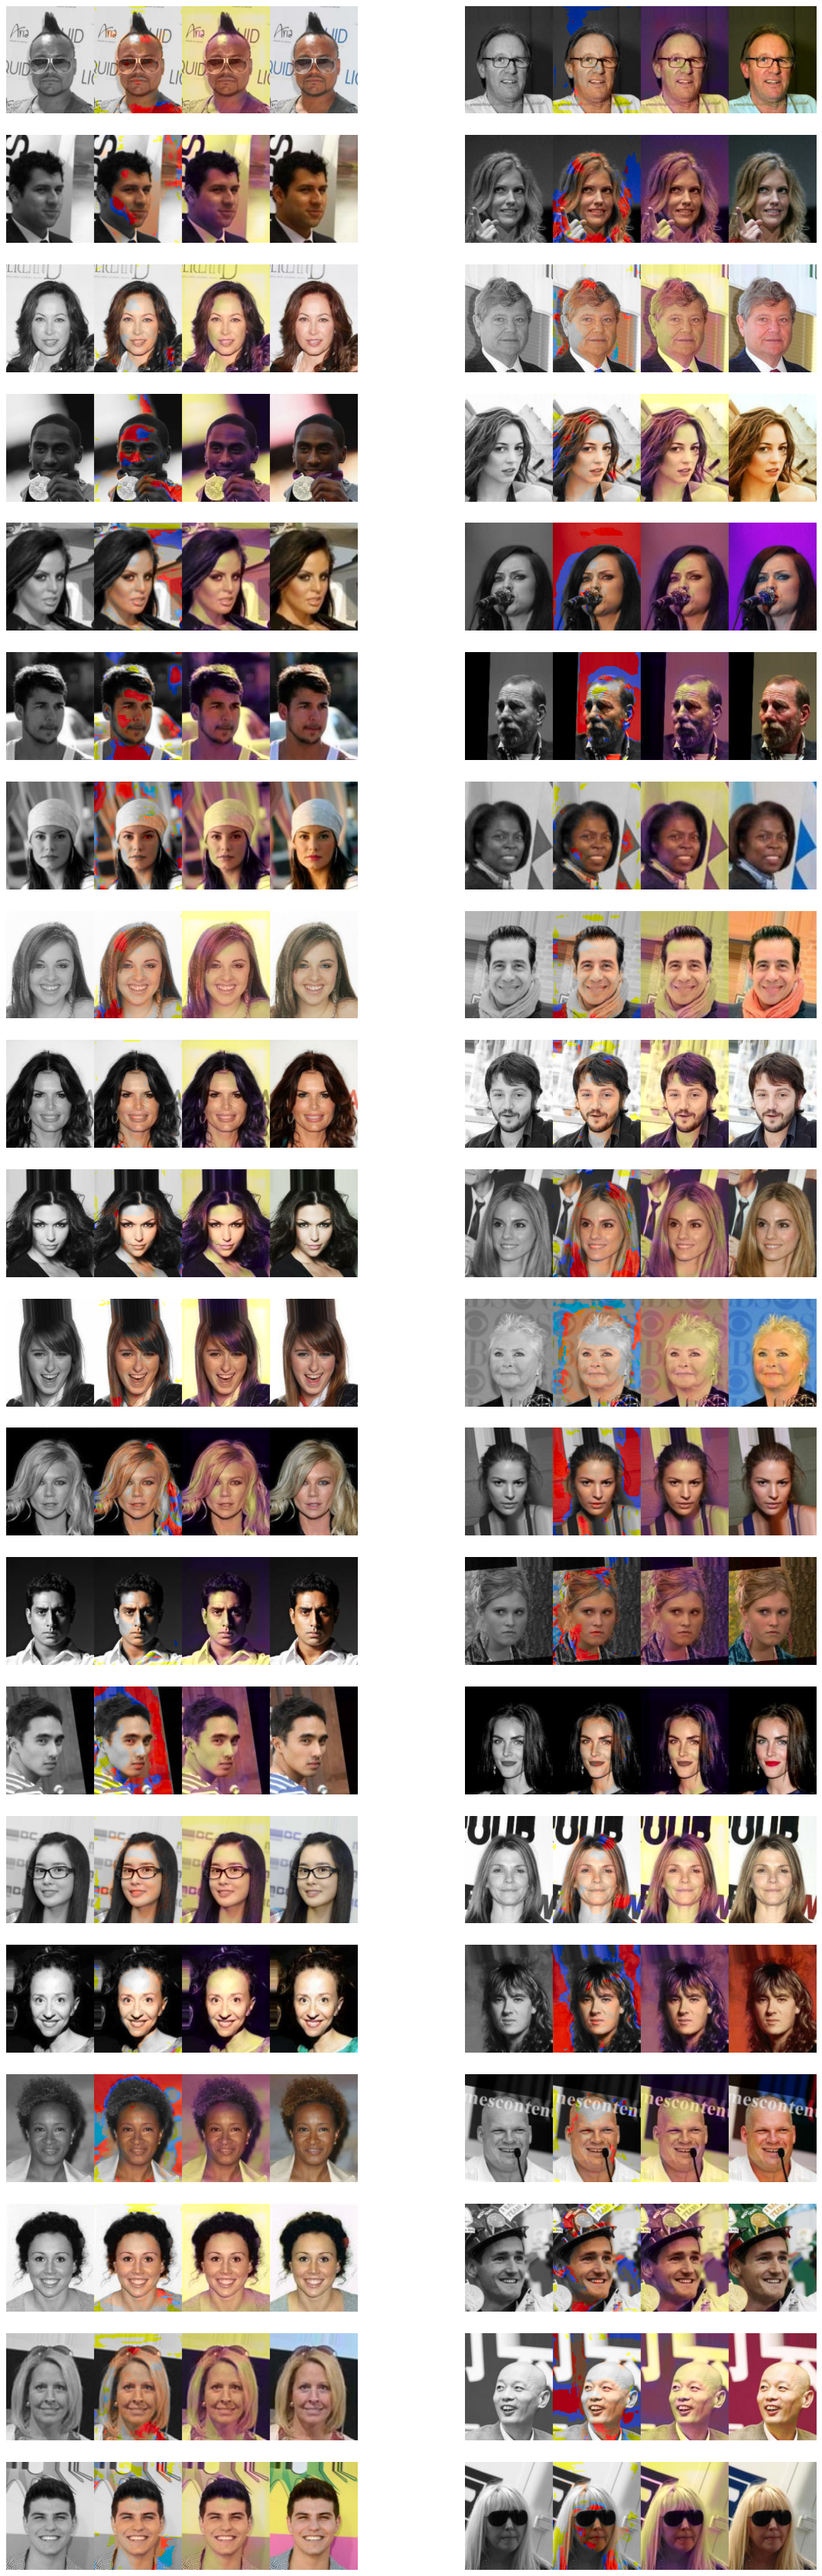

In [ ]:
lab = rgb2lab(rgb)
Lch = lab[...,0]

X = Lch[..., np.newaxis] / 100.
Y = model.predict(X)

# mode of the predicted distribution
ABch_mode = class_to_ab[np.argmax(Y, axis=-1)]

# expected value of the predicted distribution
ABch_expec = np.dot(Y, class_to_ab)

colorized = np.zeros(rgb.shape)
colorized[...,0] = Lch

colorized[...,1:] = ABch_mode
col_mode = lab2rgb(colorized)

colorized[...,1:] = ABch_expec
col_expec = lab2rgb(colorized)


lab[...,1:] = 0
grayscale = lab2rgb(lab)

imgs = np.concatenate([grayscale, col_mode, col_expec, rgb], axis=2)

show_imgs(imgs, ncols=2, save_path=str(RESULTS_DIR / "colorized_mode_vs_expec_{time:0x}.png"))

## 6. Evaluation

Again, it's hard to find a good metric to evaluate the results, in the paper Colorful Image Colorization they rely on how compelling the colors look to a human observer to evaluate the result. Anyways visually we can see that the results are not great, bright colors do appear but are not spatially coherent and in the wrong places. On the other hand when taking the expected value the patchiness is gone but the colors are basically yellow and purple in all the pictures, which is far from the ground truth and far from a compelling result.

The difference from our implementation and the paper's implementation is the use of soft encoding for the labels (theirs), and they use a bigger model with more layers and more filters per layer and also a bigger training set.

It's also possible that our model didn't properly learn because there isn't enough information about bright colors, we must remember that reweighting the loss function doesn't add information, it just changes the loss function to favor rare classes, but if the model doesn't have enough information about the rare classes it won't learn anything useful.